# Hotdog (hd vs nhd) image classifier:
# Shayan Hemmatiyan 
# Date: 08/04/2019
# Neural Magic Data Challenge

In this data challenge, I show how to start from a pretrained neural network (transfer learning) with PyTorch to train our hotdog classification model and then predict other images.

Here are the libraries required for running CNN using PyTorch:

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import cv2
import os
import keras
from torch.optim import lr_scheduler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as data
import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook
import time
import os
import copy
from torch.utils.data.sampler import SubsetRandomSampler
import itertools
from torch.utils.data import TensorDataset

Let's first check if CUDA is available for running the training on GPU:

In [14]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print("CUDA is not available. Training on CPU ... ")
else:
    print("Cuda is available: Training on GPU ...")


CUDA is not available. Training on CPU ... 


This script without losing any generality can be run on GPU using CUDA. However, I didn't have access to CUDA on my macOS. 

Here are the steps to train our CNN classifier and apply it to our system:

1- Organize the training and test sets

2- Image augmentation

3- Apply transfer learning to pre-train our image classifier (load the pre-trained model)

4- Validate our model

## 1- Organize the training and test sets

Here we define the train/test dataset loader, using the SubsetRandomSampler for the split. A training set of 310 random images from both hd and nhd (620 in total) are used for the training set and 100 random images for each hd and nhd (200 in total) for the test set:

Load the data organize the training dataset
1- Training data (620 images)
Directory for training images: train_dir = '../dataset/train'

2- Test Data (200 images)
Directory for testing images: test_dir = '../dataset/test'

## 2- Image augmentation

First, we define the data transforms. These are used by the dataset class to transform images on-the-fly. For training, we simply take random crops of size 224x224 and apply random horizontal flipping. The images are converted to PyTorch Tensors. For the test set, we scale everything to 256 and take a center crop of the same size as the training data.

In [54]:
data_transforms = {'train':
                    torchvision.transforms.Compose([
                    torchvision.transforms.RandomSizedCrop(224),
                    torchvision.transforms.RandomHorizontalFlip(),
                    torchvision.transforms.ToTensor()]),
                   'test':
                    torchvision.transforms.Compose([
                    torchvision.transforms.Scale(256),
                    torchvision.transforms.CenterCrop(224),
                    torchvision.transforms.ToTensor()])
                  }

/anaconda3/lib/python3.7/site-packages/torchvision/transforms/transforms.py:691: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  warnings.warn("The use of the transforms.RandomSizedCrop transform is deprecated, " +
/anaconda3/lib/python3.7/site-packages/torchvision/transforms/transforms.py:208: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [50]:
image_dataset = {x: torchvision.datasets.ImageFolder(os.path.join('../dataset/', x), data_transforms[x]) for x in ['train', 'test']}
data_loader = {x: DataLoader(image_dataset[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'test']}
print(image_dataset, data_loader)

{'train': Dataset ImageFolder
    Number of datapoints: 620
    Root location: ../dataset/train, 'test': Dataset ImageFolder
    Number of datapoints: 200
    Root location: ../dataset/test} {'train': <torch.utils.data.dataloader.DataLoader object at 0x1a4efb4198>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x1a4efb47b8>}


Here we can plot few images from our training data sets:

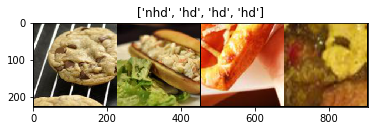

In [33]:
def imshow(imgs, title=None):
    """Imshow for Tensor."""
    imgs = imgs.numpy().transpose((1, 2, 0))
    plt.imshow(imgs)
    if title is not None:
        plt.title(title)
    
class_names =["hd", "nhd"]

# Get a batch of training data
inputs, classes = next(iter(data_loader['train']))

# Make a grid from batch
imgs = torchvision.utils.make_grid(inputs)

imshow(imgs, title=[class_names[x] for x in classes])

## 3- Apply transfer learning to pre-train our image classifier (load the pre-trained model)

Here for this data challenge, I've applied transfer learning where we freeze all the network except the final layer. FOr this purpose we need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().

I've used both Resnet18 and VGG19 models separately as the base for this data challenge.

### Resnet18
Here I have used resnet18 as the base model. The next step is defining the optimizer. 
SGD+momentum is used in this data challenge which enables finding a global minimum. However, it relies on robust initializations and it might take longer than other adaptive optimizers to converge.

For the learning rate, I've used Learning Rate Schedulers which slows down the learning rate as the training progresses. This can also help to improve the network performance. 

Since we’re doing transfer learning, we don’t need to update the weights for the conv layers. For this purpose we use pretrained=True to start with the pretrained weights. 

For the loss function, I've used CrossEntropyLoss. 

#### Training the model


In [70]:
for param in model.parameters():
    param.requires_grad = False
#print(model)

In [61]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

From the details of the model we see that the input for the last fully connected layer (linear regression) is 4096 and the output is 1000. However, in our data challenge we only have two classes hd and nhd so we have to change the out_features to a vector of size 2.

In [22]:
# Change the number of output features
model.classifier[6].out_features = 2

To ensure training the last layer we have to set require_grad flag to True.

In [23]:
# Set requires_grad to True on the linear layer
for param in model.classifier.parameters():
    param.requires_grad = True

We make use of the handy model.apply() method, supplying it with a function to initialize the weights in the Linear layers only (since Dropout and Relu layers don’t need weights initialization).



In [71]:
# Initialize the weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.kaiming_normal(m.weight.data)
        
model.classifier.apply(weights_init);




/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  """


#### Note:
The entire process for 25 epoaches takes about 15-25 min on CPU. On GPU though, it takes less than a minute.

In [62]:
# Find the device available to use using torch library
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Move model to the device specified above
model.to(device)

model_conv = torchvision.models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
    
    

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [63]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6650 Acc: 0.6387
test Loss: 0.3276 Acc: 0.8450

Epoch 1/24
----------
train Loss: 0.7374 Acc: 0.6726
test Loss: 0.3808 Acc: 0.8200

Epoch 2/24
----------
train Loss: 0.6651 Acc: 0.7097
test Loss: 0.2863 Acc: 0.8850

Epoch 3/24
----------
train Loss: 0.6957 Acc: 0.6952
test Loss: 0.4981 Acc: 0.7700

Epoch 4/24
----------
train Loss: 0.5983 Acc: 0.7306
test Loss: 0.3647 Acc: 0.8450

Epoch 5/24
----------
train Loss: 0.7848 Acc: 0.6806
test Loss: 0.3421 Acc: 0.8450

Epoch 6/24
----------
train Loss: 0.5501 Acc: 0.7484
test Loss: 0.3595 Acc: 0.8500

Epoch 7/24
----------
train Loss: 0.5050 Acc: 0.7694
test Loss: 0.2829 Acc: 0.8650

Epoch 8/24
----------
train Loss: 0.5080 Acc: 0.7677
test Loss: 0.2795 Acc: 0.8950

Epoch 9/24
----------
train Loss: 0.4965 Acc: 0.7774
test Loss: 0.2819 Acc: 0.8800

Epoch 10/24
----------
train Loss: 0.4983 Acc: 0.7694
test Loss: 0.2775 Acc: 0.8800

Epoch 11/24
----------
train Loss: 0.4668 Acc: 0.7645
test Loss: 0.2665 Acc

### VGG19: 
Additionally, we can use VGG!9 with CUDA for transfer learning. I used the tqdm package to generate handy progress bars. I’ll train for 25 epochs. I’m using an Nvidia GTX1080Ti so this runs. In the last step, we move the entire model to the GPU for training.

In [21]:
model = torchvision.models.vgg19(pretrained=True)

In [64]:
optimizer = optim.SGD(model.classifier.parameters(),lr=0.001, momentum=0.9, nesterov=True, weight_decay=1e-6)
criterion = nn.CrossEntropyLoss()

with tqdm_notebook(total=epochs,unit="epoch") as pbar:
    for epoch in range(epochs):
        running_loss = 0
        running_corrects = 0
        for i,data in enumerate(data_loader['train']):
            inputs, labels = data
            inputs = Variable(inputs.cuda())
            labels = Variable(labels.cuda())


            optimizer.zero_grad()
            outputs = model(inputs)
            preds = torch.max(outputs.data, 1)[1]
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.data[0]
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / dataset_sizes['train']
        epoch_acc = running_corrects / dataset_sizes['train']
        pbar.set_postfix(loss=epoch_loss, acc=epoch_acc)
        pbar.update()
        


'\n\noptimizer = optim.SGD(model.classifier.parameters(),lr=0.001, momentum=0.9, nesterov=True, weight_decay=1e-6)\ncriterion = nn.CrossEntropyLoss()\n\nwith tqdm_notebook(total=epochs,unit="epoch") as pbar:\n    for epoch in range(epochs):\n        running_loss = 0\n        running_corrects = 0\n        for i,data in enumerate(data_loader[\'train\']):\n            inputs, labels = data\n            inputs = Variable(inputs.cuda())\n            labels = Variable(labels.cuda())\n\n\n            optimizer.zero_grad()\n            outputs = model(inputs)\n            preds = torch.max(outputs.data, 1)[1]\n            loss = criterion(outputs, labels)\n            loss.backward()\n            optimizer.step()\n\n            running_loss += loss.data[0]\n            running_corrects += torch.sum(preds == labels.data)\n        epoch_loss = running_loss / dataset_sizes[\'train\']\n        epoch_acc = running_corrects / dataset_sizes[\'train\']\n        pbar.set_postfix(loss=epoch_loss, acc=ep

# Validation:

From the training section, we obtained 0.6952 and 0.7700 accuracy for traning and test data sets, respectively. Here we plotted 6 images from the test sets to see the instance perforamnce of our model in classifiing hd vs nhd. 

In [67]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loader['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

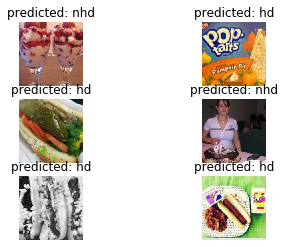

In [68]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [ ]:
Here we compute precession, recall and F1-score as the classification metrics. 

In [75]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tqdm.autonotebook import tqdm
# Get a batch of training data
inputs, classes = next(iter(data_loader['test']))

# params you need to specify:
epochs = 25
train_loader, val_loader = data_loader['train'], data_loader['test']
loss_function = nn.CrossEntropyLoss() # your loss function, cross entropy works well for multi-class problems


start_ts = time.time()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

losses = []
batches = len(train_loader)
val_batches = len(val_loader)

# loop for every epoch (training + evaluation)
for epoch in range(epochs):
    total_loss = 0

    # progress bar (works in Jupyter notebook too!)
    progress = tqdm(enumerate(train_loader), desc="Loss: ", total=batches)

    # ----------------- TRAINING  -------------------- 
    # set model to training
    model.train()
    
    for i, data in progress:
        X, y = data[0].to(device), data[1].to(device)
        
        # training step for single batch
        model.zero_grad()
        outputs = model(X)
        loss = loss_function(outputs, y)
        loss.backward()
        optimizer.step()

        # getting training quality data
        current_loss = loss.item()
        total_loss += current_loss

        # updating progress bar
        progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))
        
    # releasing unceseccary memory in GPU
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # ----------------- VALIDATION  ----------------- 
    val_losses = 0
    precision, recall, f1, accuracy = [], [], [], []
    
    # set model to evaluating (testing)
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            X, y = data[0].to(device), data[1].to(device)

            outputs = model(X) # this get's the prediction from the network

            val_losses += loss_function(outputs, y)

            predicted_classes = torch.max(outputs, 1)[1] # get class from network's prediction
            
            # calculate P/R/F1/A metrics for batch
            for acc, metric in zip((precision, recall, f1, accuracy), 
                                   (precision_score, recall_score, f1_score, accuracy_score)):
                acc.append(
                    calculate_metric(metric, y.cpu(), predicted_classes.cpu())
                )
          
    print(f"Epoch {epoch+1}/{epochs}, training loss: {total_loss/batches}, validation loss: {val_losses/val_batches}")
    print_scores(precision, recall, f1, accuracy, val_batches)
    losses.append(total_loss/batches) # for plotting learning curve
print(f"Training time: {time.time()-start_ts}s")


def calculate_metric(metric_fn, true_y, pred_y):
    # multi class problems need to have averaging method
    if "average" in inspect.getfullargspec(metric_fn).args:
        return metric_fn(true_y, pred_y, average="macro")
    else:
        return metric_fn(true_y, pred_y)
    
def print_scores(p, r, f1, a, batch_size):
    # just an utility printing function
    for name, scores in zip(("precision", "recall", "F1", "accuracy"), (p, r, f1, a)):
        print(f"\t{name.rjust(14, ' ')}: {sum(scores)/batch_size:.4f}")
        


'\n# loop for every epoch (training + evaluation)\nfor epoch in range(epochs):\n    total_loss = 0\n\n    # progress bar (works in Jupyter notebook too!)\n    progress = tqdm(enumerate(train_loader), desc="Loss: ", total=batches)\n\n    # ----------------- TRAINING  -------------------- \n    # set model to training\n    model.train()\n    \n    for i, data in progress:\n        X, y = data[0].to(device), data[1].to(device)\n        \n        # training step for single batch\n        model.zero_grad()\n        outputs = model(X)\n        loss = loss_function(outputs, y)\n        loss.backward()\n        optimizer.step()\n\n        # getting training quality data\n        current_loss = loss.item()\n        total_loss += current_loss\n\n        # updating progress bar\n        progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))\n        \n    # releasing unceseccary memory in GPU\n    if torch.cuda.is_available():\n        torch.cuda.empty_cache()\n    \n    # ------------

For this transfer learning model we obtained F1 score of 0.702.